In [ ]:
import numpy as np
import pandas as pd
import shutil
from tqdm import tqdm
from kagglehub import dataset_download
import os
from torchvision import datasets, transforms
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
# Download dataset and separate in train and val
path = dataset_download("trungit/wikiart25k")

In [14]:
# SPlit intro train and val
dataset_path = '/kaggle/input/wikiart25k'
train_ratio = 0.8
image_list = []

classes = os.listdir(dataset_path)
# Remove txt file
print(classes)

for folder in classes:
    if os.path.isdir(os.path.join(dataset_path, folder)):
        images = os.listdir(os.path.join(dataset_path, folder)) 
        for image in images:
            row = {'class': folder, 'image': image}
            image_list.append(row)
np.random.shuffle(image_list)
df = pd.DataFrame(image_list)


['Pop_Art', 'Minimalism', 'Color_Field_Painting', 'Mannerism_Late_Renaissance', 'Symbolism', 'Impressionism', 'Contemporary_Realism', 'High_Renaissance', 'Fauvism', 'Rococo', 'Early_Renaissance', 'Naive_Art_Primitivism', 'Pointillism', 'Cubism', 'Synthetic_Cubism', 'Action_painting', 'Abstract_Expressionism', 'New_Realism', 'Baroque', 'Analytical_Cubism', 'Expressionism', 'Romanticism', 'wikiart25k.txt', 'Northern_Renaissance', 'Ukiyo_e', 'Post_Impressionism', 'Art_Nouveau_Modern', 'Realism']


In [15]:
df.head()
len(df)

25000

In [16]:
length_train = int(len(df) * train_ratio)
length_val = len(df) - length_train
print(length_train)
print(length_val)

train_df = df.iloc[:length_train]
test_df = df.iloc[length_train:]

20000
5000


In [17]:
assert len(np.unique(test_df['class'].values)) == len(np.unique(train_df['class'].values))

In [18]:
# Creating train and val folders in Kaggle
working_folder = '/kaggle/working/wikiart25k'
train_folder = os.path.join(working_folder, 'train')
val_folder = os.path.join(working_folder, 'val')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Train folder
for _, row in tqdm(train_df.iterrows()):
    category = row['class']
    image = row['image']
    src = os.path.join(dataset_path, category, image)
    dst_dir = os.path.join(train_folder, category)
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, image)
    if not os.path.isfile(dst):
        shutil.copy(src, dst)

20000it [00:07, 2584.02it/s]


In [19]:
# Test folder
for _, row in tqdm(test_df.iterrows()):
    category = row['class']
    image = row['image']
    src = os.path.join(dataset_path, category, image)
    dst_dir = os.path.join(val_folder, category)
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, image)
    if not os.path.isfile(dst):
        shutil.copy(src, dst)

5000it [00:11, 429.00it/s]


In [ ]:
# Creating the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# from resnet50 torch doc

IMAGE_SIZE = 256
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Setting datasets with the folders

train_dataset = datasets.ImageFolder(train_folder, transform=train_transform)
val_dataset = datasets.ImageFolder(val_folder, transform=val_transform)

# Setting dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

class_names = train_dataset.classes
num_classes = len(class_names)

cuda


In [21]:
# Setting up the model : ResNet50

model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [22]:
# Training model

classes = train_dataset.classes
num_classes = len(classes)

epochs = 14
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=1e-5)
# scheduler ? à voir...
best_acc = 0.0

for epoch in range(epochs):
    print(f"Epoch {epoch} starting...")
    # Train
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"🎯 Epoch {epoch}: val_acc = {val_acc:.4f}")

    # Sauvegarde du meilleur modèle
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/wikiart25k/best_wikiart_resnet50.pth")

Epoch 0 starting...


100%|██████████| 281/281 [01:28<00:00,  3.18it/s]


🎯 Epoch 0: val_acc = 0.4377
Epoch 1 starting...


100%|██████████| 281/281 [01:28<00:00,  3.18it/s]


🎯 Epoch 1: val_acc = 0.5428
Epoch 2 starting...


100%|██████████| 281/281 [01:25<00:00,  3.27it/s]


🎯 Epoch 2: val_acc = 0.6161
Epoch 3 starting...


100%|██████████| 281/281 [01:26<00:00,  3.26it/s]


🎯 Epoch 3: val_acc = 0.6717
Epoch 4 starting...


100%|██████████| 281/281 [01:28<00:00,  3.19it/s]


🎯 Epoch 4: val_acc = 0.7291
Epoch 5 starting...


100%|██████████| 281/281 [01:27<00:00,  3.20it/s]


🎯 Epoch 5: val_acc = 0.7805
Epoch 6 starting...


100%|██████████| 281/281 [01:26<00:00,  3.26it/s]


🎯 Epoch 6: val_acc = 0.8228
Epoch 7 starting...


100%|██████████| 281/281 [01:30<00:00,  3.10it/s]


🎯 Epoch 7: val_acc = 0.8529
Epoch 8 starting...


100%|██████████| 281/281 [01:28<00:00,  3.18it/s]


🎯 Epoch 8: val_acc = 0.8830
Epoch 9 starting...


100%|██████████| 281/281 [01:26<00:00,  3.27it/s]


🎯 Epoch 9: val_acc = 0.8993


In [23]:
!ls /kaggle/working/wikiart25k

best_wikiart_resnet50.pth  train  val


In [24]:
# Download locally
from IPython.display import FileLink
%cd /kaggle/working
%ls wikiart25k
FileLink(r'wikiart25k/best_wikiart_resnet50.pth')

/kaggle/working
best_wikiart_resnet50.pth  train/  val/


/kaggle/working/wikiart25k/best_wikiart_resnet50.pth

<a href="/kaggle/working/wikiart25k/best_wikiart_resnet50.pth"> Download File </a>

In [35]:
# Charger meilleur modèle
print('Loading model...')
model.load_state_dict(torch.load("wikiart25k/best_wikiart_resnet50.pth"))
print('Model loaded!')
model.eval()

Loading model...
Model loaded!


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

100%|██████████| 281/281 [01:29<00:00,  3.15it/s]


                            precision    recall  f1-score   support

    Abstract_Expressionism       0.85      0.89      0.87       296
           Action_painting       1.00      0.08      0.15        12
         Analytical_Cubism       0.80      0.75      0.77        16
        Art_Nouveau_Modern       0.91      0.89      0.90       494
                   Baroque       0.93      0.93      0.93       464
      Color_Field_Painting       0.88      0.84      0.86       178
      Contemporary_Realism       0.75      0.81      0.78        59
                    Cubism       0.86      0.91      0.89       235
         Early_Renaissance       0.88      0.93      0.91       153
             Expressionism       0.89      0.83      0.86       715
                   Fauvism       0.87      0.81      0.84       100
          High_Renaissance       0.85      0.90      0.87       146
             Impressionism       0.89      0.96      0.92      1468
Mannerism_Late_Renaissance       0.90      0.86

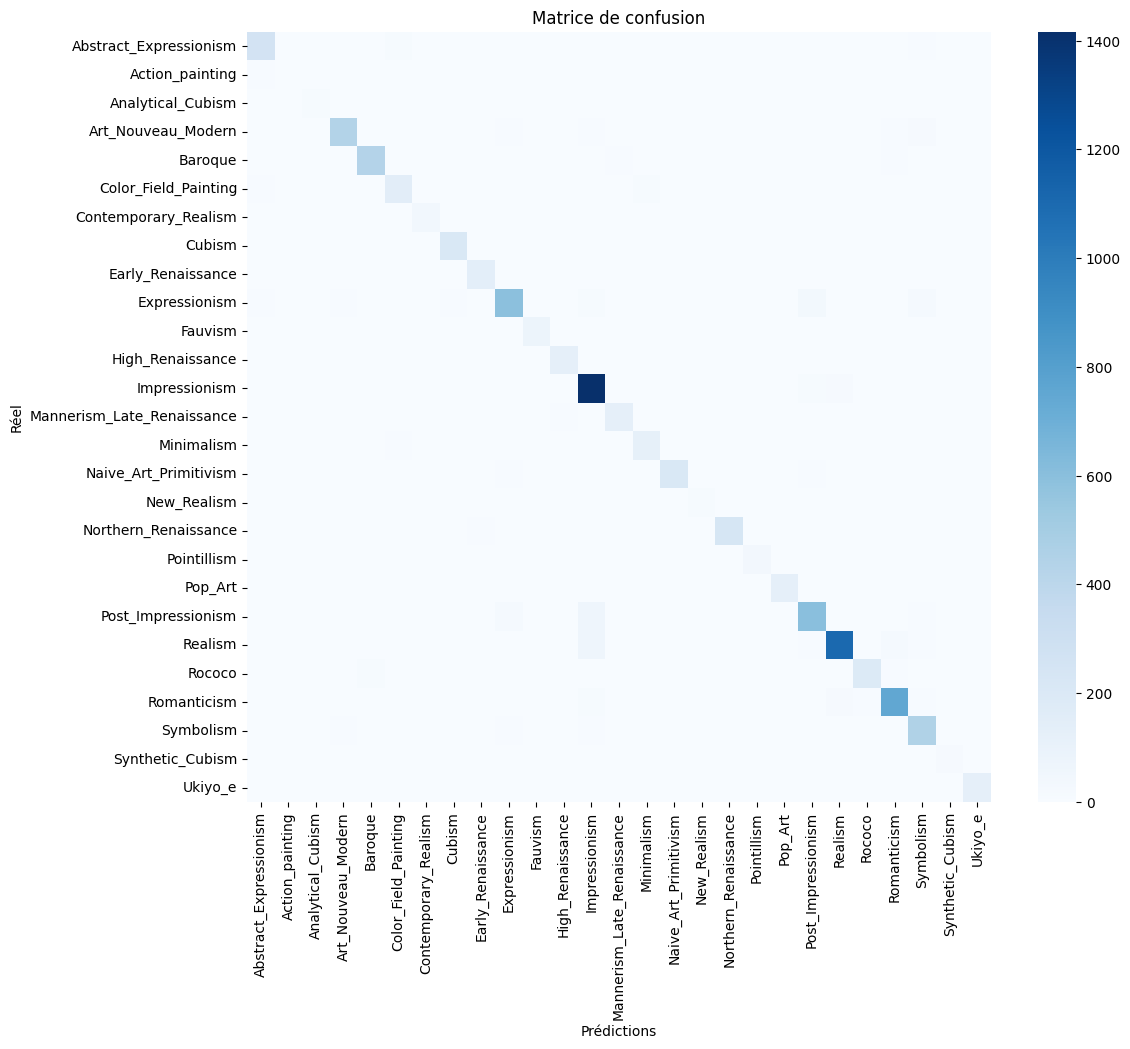

In [36]:
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_dataloader):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Rapport
print(classification_report(all_labels, all_preds, target_names=class_names))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()
